# Percepção Computacional - Gunshot Audio Dataset

Dataset: [Gunshot Audio Dataset](https://www.kaggle.com/datasets/emrahaydemr/gunshot-audio-dataset)

**Antes de rodar a célula de download:** configure as credenciais do Kaggle (uma vez por máquina).

1. Em [Kaggle → Account → API](https://www.kaggle.com/settings), clique em "Create Legacy API Key" que será baixado um kaggle.json, mova-o para esse diretório (Existe um kaggle.exemple.json com o formato desejado). Configure também o .env usando como referência o .env.exemple



## Objetivo do trabalho

Este notebook investiga uma abordagem de **classificação de áudio de armas** com base no som dos disparos.

A estratégia adotada é converter os sinais em **mel-espectrogramas** e usar uma **rede neural convolucional (CNN)** para aprender padrões discriminativos entre as classes de armamento.

## Imports e Preparação do ambiente

In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi
import json
import os
from pathlib import Path
import librosa
from tqdm import tqdm
from IPython.display import Audio

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers


2026-02-21 08:28:29.605360: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-21 08:28:30.884169: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-21 08:28:36.095139: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:

raiz = Path(".").resolve()
with open(raiz / "kaggle.json", encoding="utf-8") as f:
    cred = json.load(f)
os.environ["KAGGLE_USERNAME"] = cred["username"]
os.environ["KAGGLE_KEY"] = cred["key"]



In [3]:
api = KaggleApi()
api.authenticate()

path = Path("data")
path.mkdir(exist_ok=True)

api.dataset_download_files(
    "emrahaydemr/gunshot-audio-dataset",
    path=str(path),
    unzip=True,
)
print("Dataset baixado em:", path.resolve())

Dataset URL: https://www.kaggle.com/datasets/emrahaydemr/gunshot-audio-dataset
Dataset baixado em: /home/orlandojunior/percepcao-computacional/data


## Análise Exploratória de Dados

A análise exploratória é importante para entender o comportamento acústico inicial do dataset antes do treinamento.

Nesta parte, são observados exemplos de diferentes armas no domínio do tempo e da frequência, permitindo verificar variações de intensidade, conteúdo espectral e possíveis semelhanças entre classes.

O código abaixo separa uma lista com o segundo exemplo de audio de cada arma

In [4]:
data_dir = Path('./data')
lista_exemplos = []

for pasta in data_dir.iterdir():
    if pasta.is_dir():

        arquivos = list(pasta.glob('*.wav'))

        if arquivos:
            lista_exemplos.append(arquivos[1])
num_arquivos = len(lista_exemplos)

num_arquivos, lista_exemplos


(9,
 [PosixPath('data/MP5/8 (2).wav'),
  PosixPath('data/Zastava M92/9 (34).wav'),
  PosixPath('data/M4/4 (68).wav'),
  PosixPath('data/IMI Desert Eagle/2 (5).wav'),
  PosixPath('data/AK-47/1 (43).wav'),
  PosixPath('data/AK-12/3 (13).wav'),
  PosixPath('data/M249/6 (68).wav'),
  PosixPath('data/M16/5 (99).wav'),
  PosixPath('data/MG-42/7 (10).wav')])

Exemplo de um áudio da base

In [5]:

file = './data/AK-47/1 (10).wav'
Audio(file)

In [6]:
sample_test, sr_test = librosa.load(file, sr=None, mono=True)

len(sample_test), sr_test, sample_test

/home/orlandojunior/miniconda3/envs/percepcao/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(96000,
 48000,
 array([ 0.00215149, -0.0380249 ,  0.06178284, ..., -0.11155701,
        -0.139328  , -0.11264038], dtype=float32))

O código abaixo declara as funções para plotagem de gráficos da **amplitude x tempo** e **Espectro de Frequência** de cada item da lista *lista_exemplos*
Link do site de herman para estudo sobre: https://dropsofai.com/understanding-audio-data-fourier-transform-fft-and-spectrogram-features-for-a-speech-recognition-system/

In [7]:
def plot_amplitude_time(lista_exemplos):
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))

    axes_flat = axes.flatten()

    for i, caminho in enumerate(lista_exemplos):
        y, sr = librosa.load(caminho, sr=None, mono=True)
        
        librosa.display.waveshow(y, sr=sr, ax=axes_flat[i])
        
        axes_flat[i].set_title(f"Fonte: {caminho.parent.name} - Arquivo: {caminho.name}")
        axes_flat[i].set_ylabel("Amplitude")

    plt.tight_layout()
    plt.show()

def plot_fft_grid(lista_exemplos):
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    axes_flat = axes.flatten()
    
    for i, caminho in enumerate(lista_exemplos):
            
        y, sr = librosa.load(caminho, sr=None, mono=True)
        n = len(y)
        yf = np.fft.fft(y)
        xf = np.linspace(0.0, sr/2.0, n//2)

        axes_flat[i].plot(xf, 2.0/n * np.abs(yf[:n//2]))
        
        axes_flat[i].set_title(f"FFT: {caminho.parent.name}", fontsize=10)
        axes_flat[i].set_xlabel("Frequência (Hz)")
        axes_flat[i].set_ylabel("Magnitude")

    plt.tight_layout()
    plt.show()

def plot_stft_grid(lista_exemplos):
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    axes_flat = axes.flatten()

    for i, caminho in enumerate(lista_exemplos):
            
        y, sr = librosa.load(caminho, sr=None)
        
        D = librosa.stft(y)
        D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
        
        img = librosa.display.specshow(D_db, sr=sr, x_axis='time', y_axis='hz', 
                                      ax=axes_flat[i], cmap='magma')
        
        axes_flat[i].set_title(f"STFT: {caminho.parent.name}", fontsize=10)
        axes_flat[i].set_ylabel("Hz")
        axes_flat[i].set_xlabel("Tempo (s)")

    plt.tight_layout()
    plt.show()


Amplitude x Time

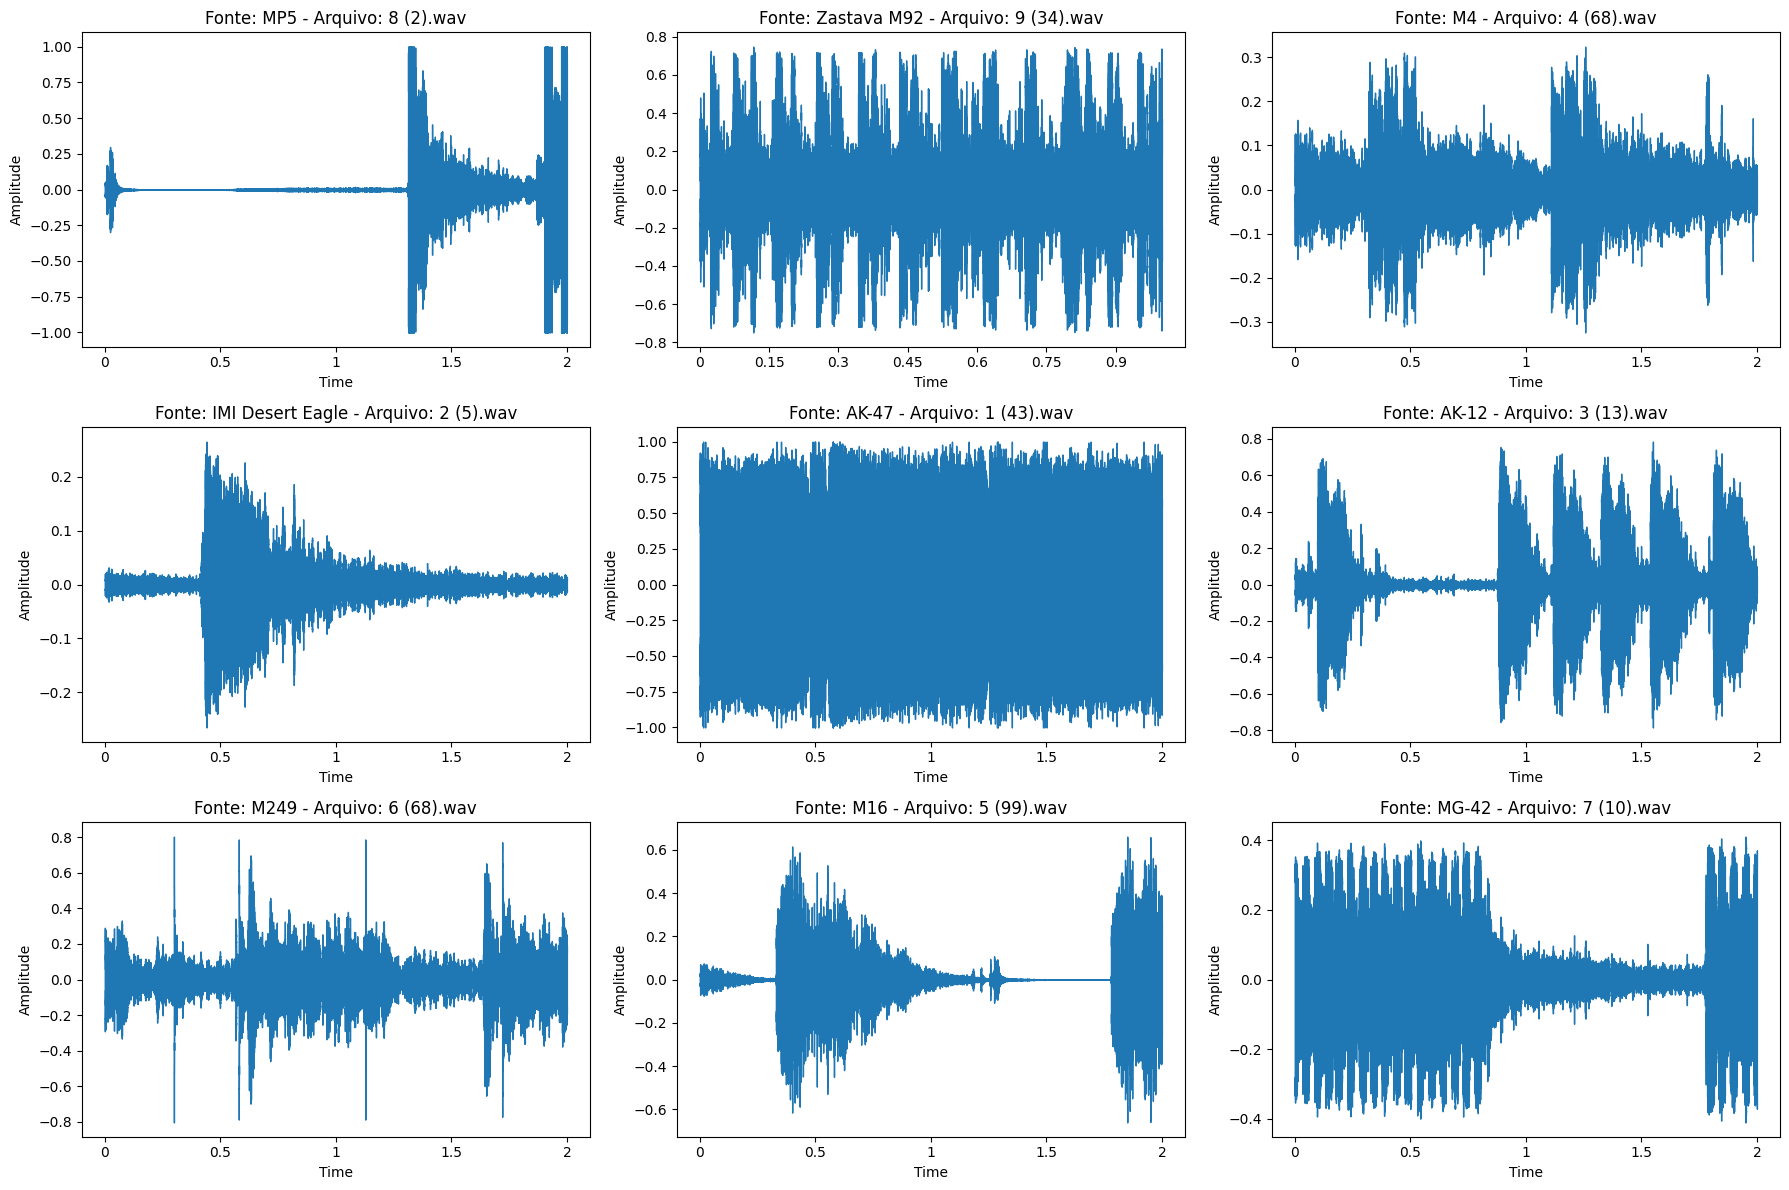

In [8]:
plot_amplitude_time(lista_exemplos)

Magnitude x Frequência

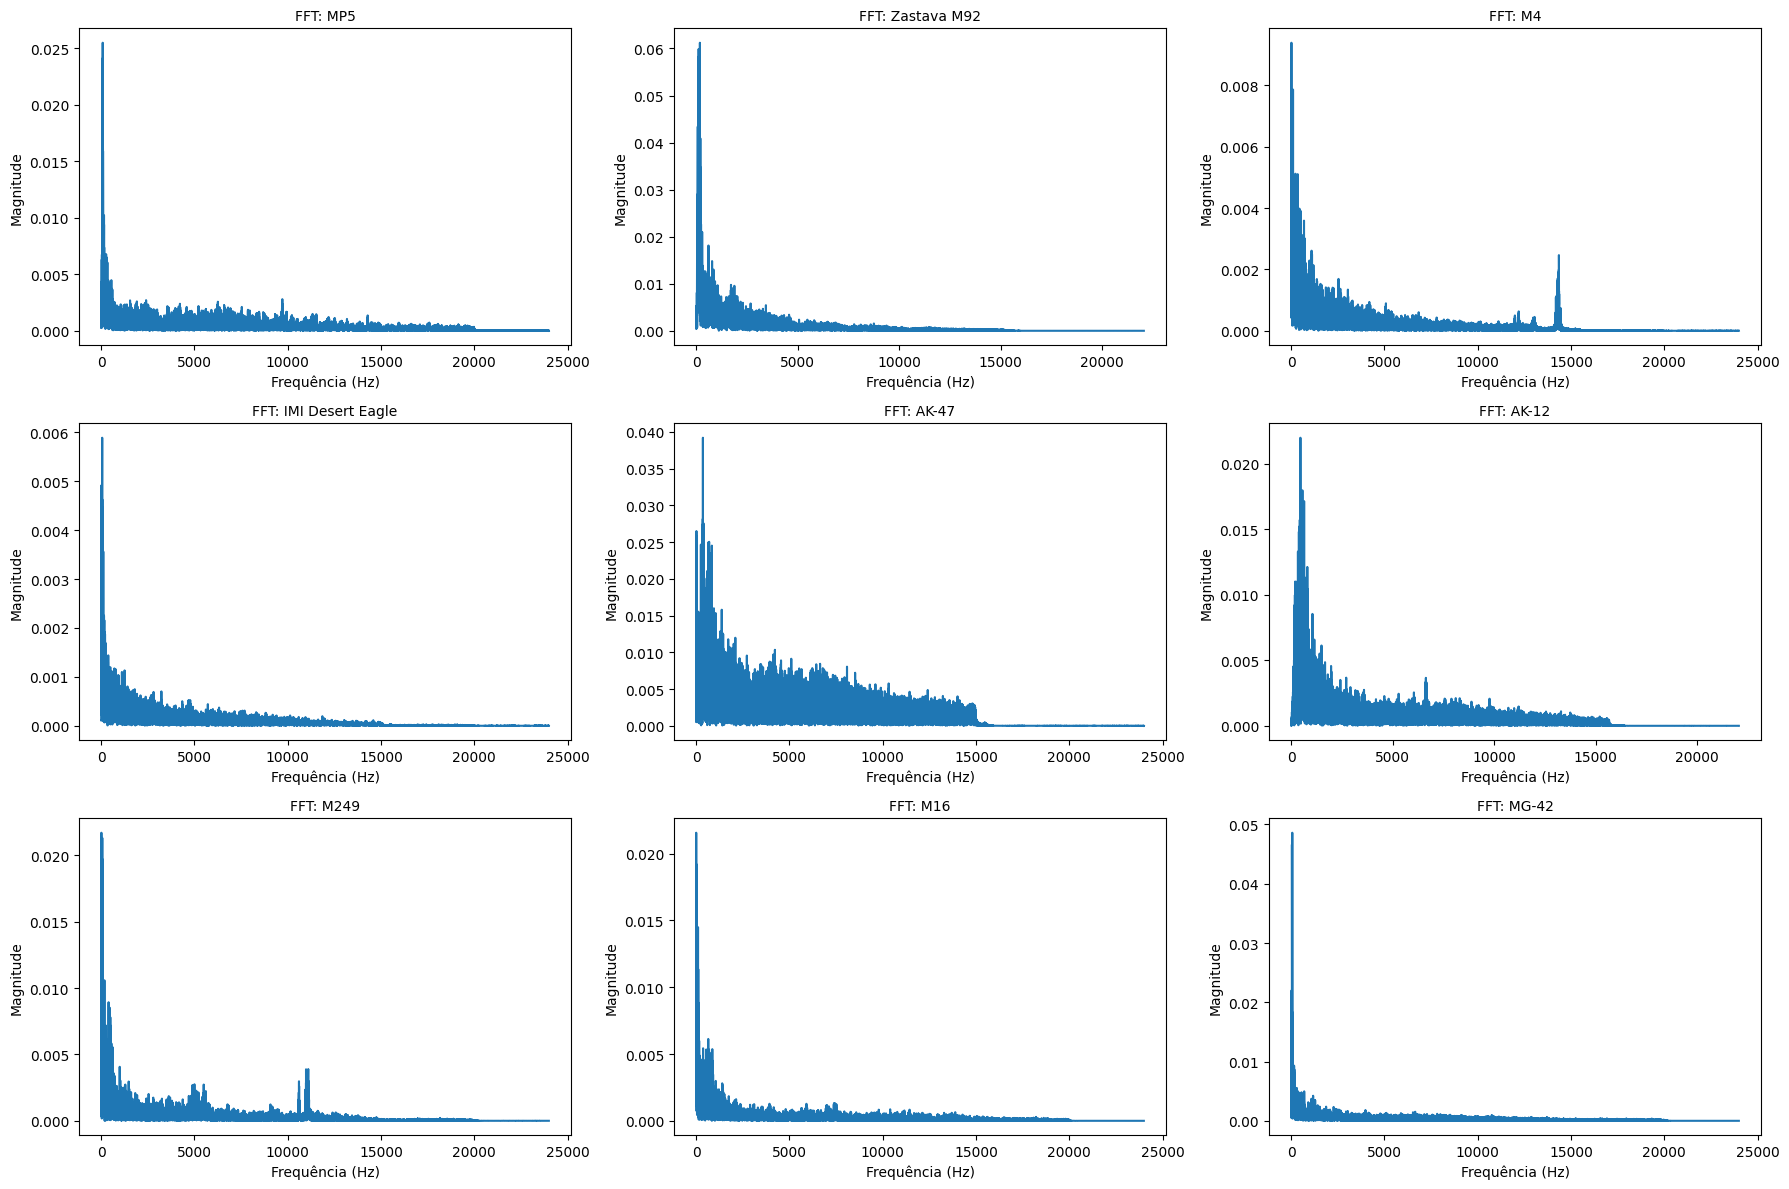

In [9]:
plot_fft_grid(lista_exemplos)

Short-Time Fourier Transform (STFT)

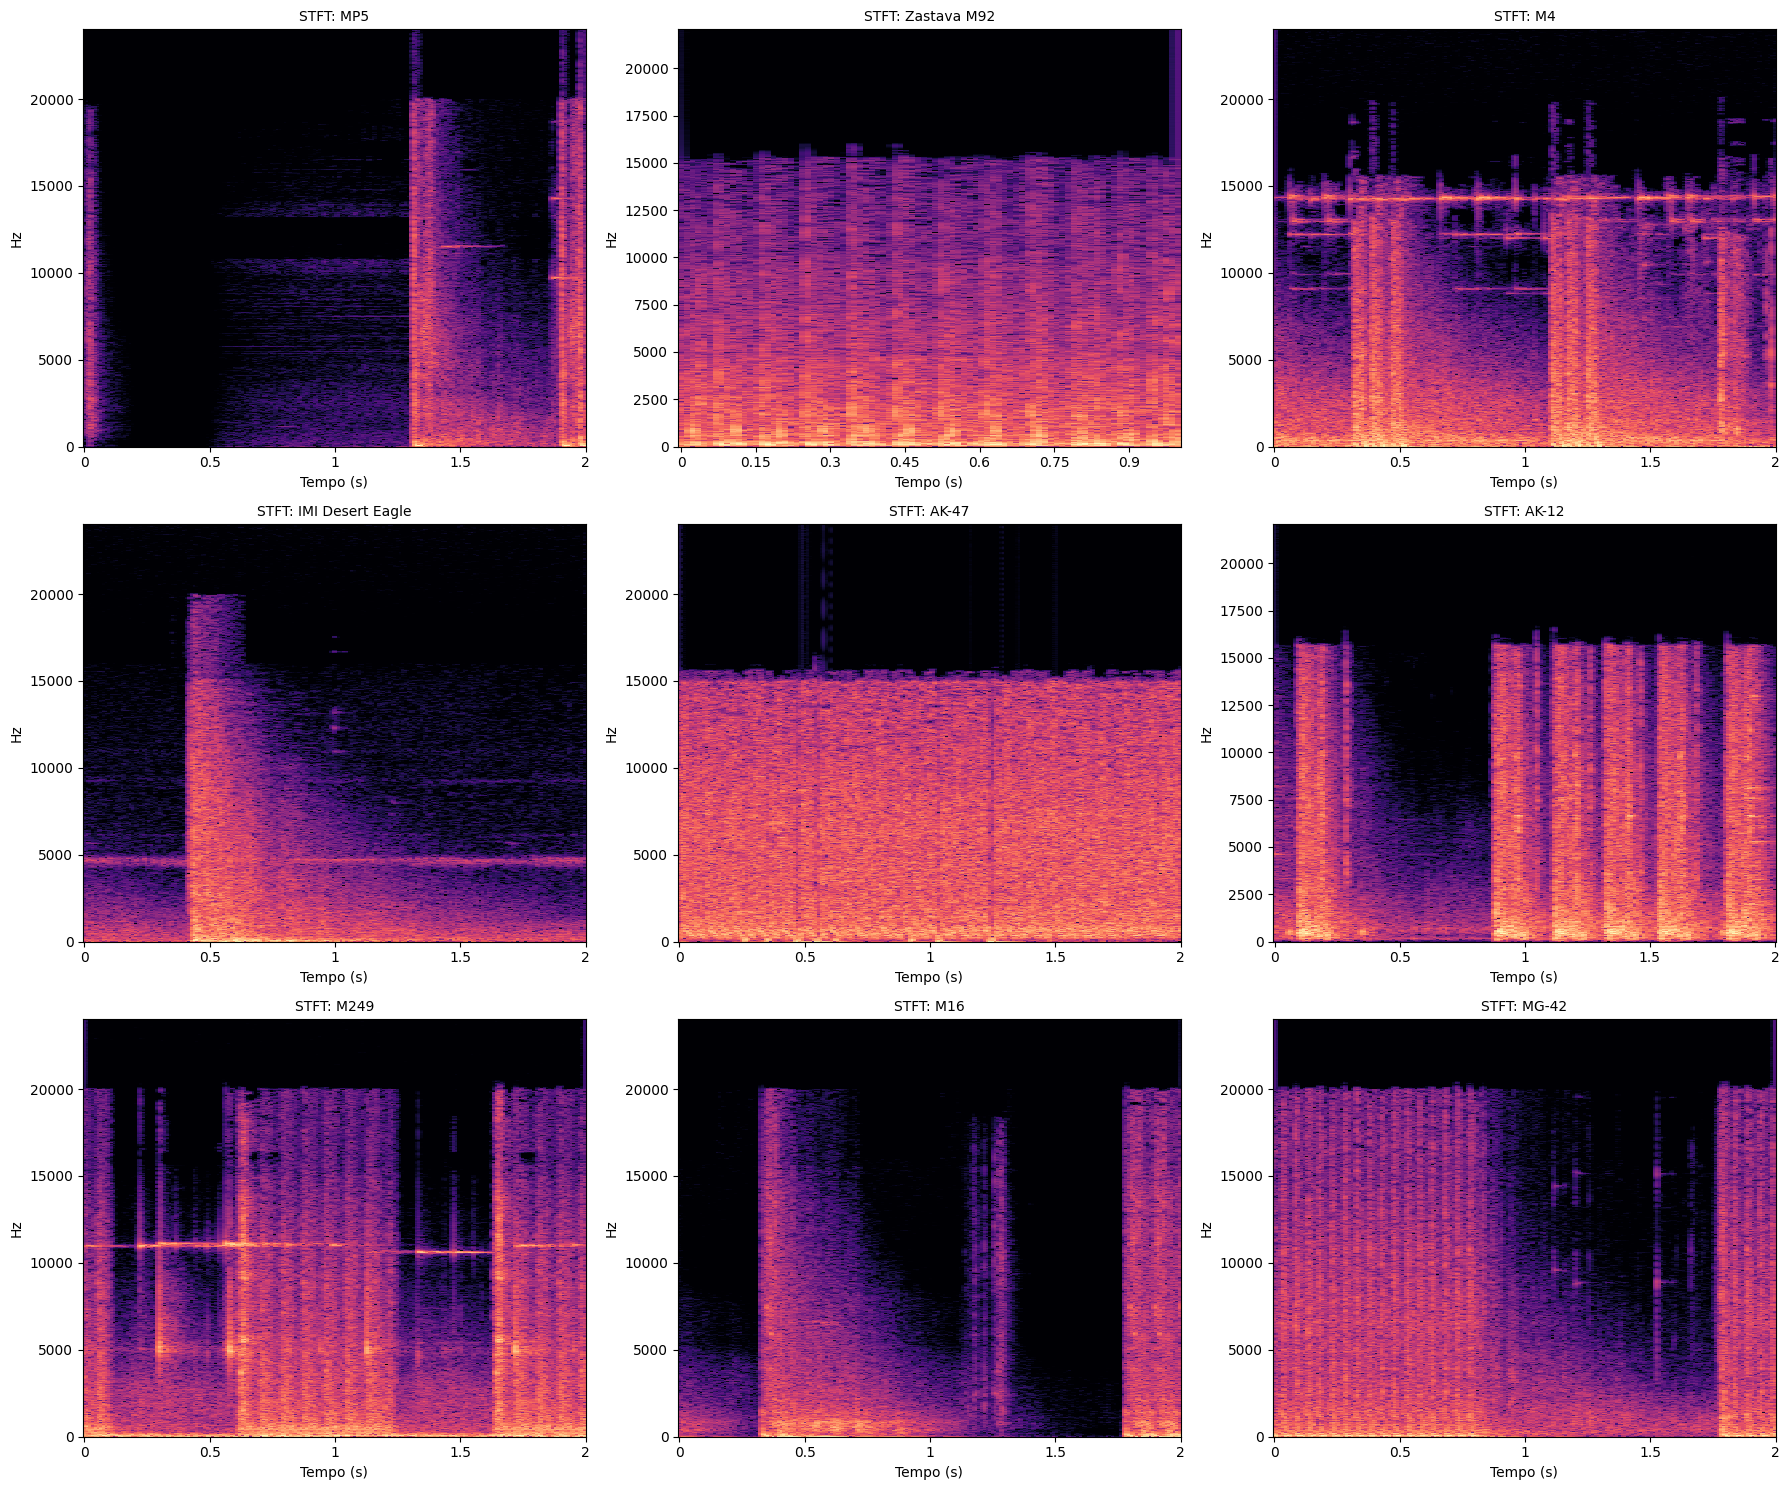

In [10]:
plot_stft_grid(lista_exemplos)

## Aprendizagem de Máquina e Preparação do Dataset

O librosa.load decodifica o áudio para números, mas o array bruto y é uma representação de áudio de 1 segundo com sr=22050 que gera um vetor de 22.050 números. É muita informação com muita redundância e ruído, o que dificulta o aprendizado do modelo.

Função para criar uma tabela simples que diz onde está o arquivo e qual é a classe dele

In [11]:
def criar_dataframe_arquivos(diretorio_base):
    lista_arquivos = []

    for label in os.listdir(diretorio_base):
        path_classe = os.path.join(diretorio_base, label)
        
        # Verifica se é uma pasta
        if os.path.isdir(path_classe):
            
            # Agora percorre os arquivos de áudio dentro da pasta da arma
            for nome_arquivo in os.listdir(path_classe):
                # Filtra apenas arquivos de áudio (se houver lixo ou txt, ignora)
                if nome_arquivo.lower().endswith(('.wav', '.mp3')):
                    path_completo = os.path.join(path_classe, nome_arquivo)
                    
                    # Adiciona a lista
                    lista_arquivos.append({
                        'filepath': path_completo,
                        'label': label
                    })

    # Transforma a lista em DataFrame do Pandas
    df = pd.DataFrame(lista_arquivos)
    
    return df

In [12]:
df_audios = criar_dataframe_arquivos(path)


In [13]:
print(f"Quantidade de dados: {df_audios.value_counts('label').sum()}\n")
print(df_audios.value_counts('label'))

Quantidade de dados: 851

label
IMI Desert Eagle    100
MP5                 100
M16                 100
MG-42               100
M4                  100
M249                 99
AK-12                98
Zastava M92          82
AK-47                72
Name: count, dtype: int64


Considero os dados balanceados, mesmo tendo uma diferença de 28 dados a menos entre Ak-47 e as classes com 100. 

Dividir os dados em treino, validação e teste

In [14]:
X = df_audios['filepath']  
y = df_audios['label']

In [15]:
X.shape, y.shape

((851,), (851,))

In [16]:
y

0        MP5
1        MP5
2        MP5
3        MP5
4        MP5
       ...  
846    MG-42
847    MG-42
848    MG-42
849    MG-42
850    MG-42
Name: label, Length: 851, dtype: object

In [17]:
X

0        data/MP5/8 (95).wav
1         data/MP5/8 (2).wav
2         data/MP5/8 (1).wav
3        data/MP5/8 (84).wav
4        data/MP5/8 (78).wav
               ...          
846    data/MG-42/7 (12).wav
847    data/MG-42/7 (93).wav
848    data/MG-42/7 (42).wav
849    data/MG-42/7 (27).wav
850    data/MG-42/7 (73).wav
Name: filepath, Length: 851, dtype: object

### Justificativa da divisão de dados

A separação em treino, validação e teste é necessária para evitar avaliação enviesada.

- **Treino**: ajuste dos pesos da rede.
- **Validação**: seleção de hiperparâmetros e controle de overfitting.
- **Teste**: estimativa final de desempenho em dados não vistos.

O uso de `stratify` mantém a proporção das classes em todas as partições.

Dividir os dados entre 70% Treino 15% Validação e 15% teste

In [18]:
X_train_val,X_test, y_train_val, y_test = train_test_split(X,y,test_size=0.15, random_state=42, stratify=y)
X_train,X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.176, random_state=42,stratify=y_train_val)

In [19]:
print(f"Shape X_train: {X_train.shape}")
print(f"Tipo do dado: {type(X_train)}")

Shape X_train: (595,)
Tipo do dado: <class 'pandas.core.series.Series'>


A ideia vai ser transformar esses arquivos de áudio em imagens para que a rede neural possa conseguir enxergar.
Vamos gerar os Mel-Spectrograms e usar CNNs, uma questão importante é que Redes Neurais (CNNs) exigem que todas as entradas tenham exatamente o mesmo tamanho, como percebe-se que todos os audios tem o mesmo tamanho (2s) parece ser uma aplicação interessante.

No exemplo único que foi apresentado no início, observa-se:

![image.png](attachment:image.png)

(sr=48000): Isso é qualidade de estúdio (acima de CD, que é 44.1kHz). Significa que o arquivo tem 48.000 pontos de dados por segundo.Em 2 segundos: $48.000 \times 2 = 96.000$ números (floats).

Com (sr=22050): Isso é o padrão em tarefas de Speech/Audio Classification. Para identificar que arma é, dificilmente precisamos das frequências ultra-agudas acima de 11kHz (Limite de Nyquist de 22kHz). Reduzir de 48k para 22k corta o tamanho do dado pela metade sem perder a "assinatura" grave e média do tiro. Isso faz sua Rede Neural treinar 2x mais rápido e ocupar metade da RAM da GPU.

É preciso definir qual a altura da imagem, nesse primeiro teste farei com 128 de altura n_mels=128 e HOP_LENGTH = 512. HOP_LENGTH define a LARGURA da sua imagem. O algoritmo (STFT) não analisa o áudio todo de uma vez, ele vai deslizando uma janela pelo áudio.hop_length é o "passo" que essa janela dá.

Assim, a cada 512 amostras, ele tira uma "foto" do som.

- Total de amostas (em 22k): 22050 Hz x 2s = 44100 amostas
- Largura da imagem = Total/Hop = 44100/512 = 86 a 87 pixels

Ao usar esses parâmetros, estamos transformando aquele vetor de 96.000 números (que você viu no seu print) em uma imagem compacta de 128 x 87 pixels. Isso é muito mais fácil para a CNN processar do que o dado bruto, e contém a informação visual da "explosão" do tiro.

In [20]:
# --- 1. Configurações de Áudio e Imagem ---
SAMPLE_RATE = 22050
DURATION = 2.0   # Duração fixa de 2 segundos
N_MELS = 128     # Altura da imagem (eixo Y - frequências)
HOP_LENGTH = 512 # Passo da janela (afeta a largura da imagem)

# Número exato de amostras que precisamos (2 segundos * 22050 Hz)
SAMPLES_FIXOS = int(SAMPLE_RATE * DURATION)

Função para extrair as features

A função de extração abaixo aplica três cuidados essenciais para a qualidade dos dados:

1. **Reamostragem e duração fixa** para padronizar todas as entradas.
2. **Conversão para escala log (dB)**, que aproxima melhor a percepção auditiva.
3. **Canal explícito** no final do tensor para compatibilidade com camadas convolucionais 2D.

In [21]:
def add_noise(y, noise_factor=0.005):
    noise = np.random.randn(len(y))
    augmented_y = y + noise_factor * noise
    return augmented_y

def time_shift(y, shift_max=0.2):
    shift = np.random.randint(int(len(y) * shift_max))
    return np.roll(y, shift)

def extrair_features(file_path, augment= False, choice = None):
    try:
        # Carrega o áudio
        # res_type='kaiser_fast' agiliza o carregamento
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE, res_type='kaiser_fast')

        if augment:
            if choice == "noise":
                y = add_noise(y)
            elif choice == "shift":
                y = time_shift(y)

        # Garante o tamanho exato (Padding ou Corte)
        # Mesmo que tenham 2s, isso previne erros de arredondamento
        if len(y) < SAMPLES_FIXOS:
            y = librosa.util.fix_length(y, size=SAMPLES_FIXOS)
        else:
            y = y[:SAMPLES_FIXOS]

        # Gera o Mel-Spectrogram
        melspec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, hop_length=HOP_LENGTH)
        
        # Converte para Decibéis (Log-Scale) -> Isso é o que "vemos" como imagem
        melspec_db = librosa.power_to_db(melspec, ref=np.max)

        # Adiciona a dimensão do canal (Necessário para CNNs: Altura, Largura, Canais)
        # Resultado final será algo como (128, 87, 1)
        melspec_db = melspec_db[..., np.newaxis]
        
        return melspec_db

    except Exception as e:
        print(f"Erro no arquivo {file_path}: {e}")
        return None



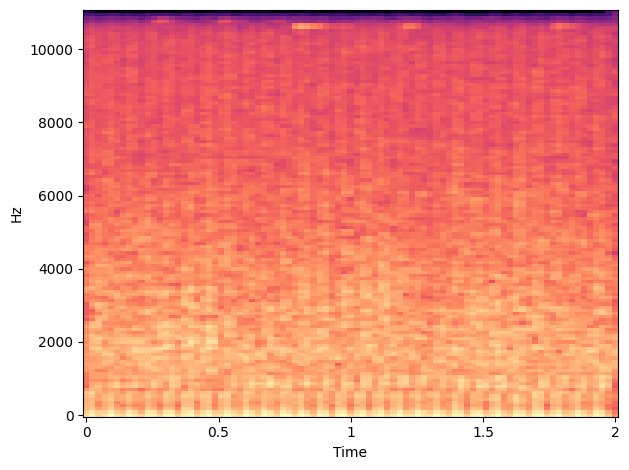

In [22]:
# Exemplo de imagem que vai pra CNN
plot = plt.plot(figsize=(20,20))
file_path = "./data/M249/6 (12).wav"

y, sr = librosa.load(file_path, sr=SAMPLE_RATE, res_type='kaiser_fast')

melspec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, hop_length=HOP_LENGTH)
        
# Converte para Decibéis (Log-Scale) -> Isso é o que "vemos" como imagem
melspec_db = librosa.power_to_db(melspec, ref=np.max)

img = librosa.display.specshow(melspec_db, sr=sr, x_axis='time', y_axis='hz', cmap='magma')

plt.tight_layout()
plt.show()

### Montagem dos tensores de treino, validação e teste

A seguir, os mel-espectrogramas são gerados para cada partição e organizados em arrays NumPy com shape consistente para a CNN.

No treino, o dataset é expandido com versões aumentadas (ruído e deslocamento temporal), enquanto validação e teste permanecem sem aumento para medir desempenho realista.

In [23]:
# --- 1. GERAÇÃO DOS DADOS DE TREINO (Aumentados) ---
print("Gerando espectrogramas de TREINO (Originais)...")
X_train_orig = [extrair_features(f, augment=False) for f in tqdm(X_train)]

print("Gerando espectrogramas de TREINO (Com Ruído)...")
X_train_noise = [extrair_features(f, augment=True, choice="noise") for f in tqdm(X_train)]

print("Gerando espectrogramas de TREINO (Com Shift)...")
X_train_shift = [extrair_features(f, augment=True, choice="shift") for f in tqdm(X_train)]

# Concatena as listas e converte para Array Numpy
X_train_final = np.array(X_train_orig + X_train_noise + X_train_shift)

# --- 2. GERAÇÃO DOS DADOS DE VALIDAÇÃO E TESTE (Originais) ---
print("Gerando espectrogramas de VALIDAÇÃO...")
X_val_final = np.array([extrair_features(f) for f in tqdm(X_val)])

print("Gerando espectrogramas de TESTE...")
X_test_final = np.array([extrair_features(f) for f in tqdm(X_test)])

# --- 3. TRATAMENTO DOS RÓTULOS (Labels) ---
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train) # Labels originais numéricos

# REPETIR os rótulos 3 vezes para alinhar com o X_train_final (Original + Noise + Shift)
y_train_final = np.concatenate([y_train_encoded, y_train_encoded, y_train_encoded])

y_val_num = le.transform(y_val)
y_test_num = le.transform(y_test)

# --- 4. SHUFFLE ---
# Embaralha X e y simultaneamente para misturar originais e aumentados
X_train_final, y_train_final = shuffle(X_train_final, y_train_final, random_state=42)

print("-" * 30)
print(f"Treino: {X_train_final.shape} | Labels: {y_train_final.shape}")
print(f"Validação: {X_val_final.shape} | Labels: {y_val_num.shape}")
print("-" * 30)

Gerando espectrogramas de TREINO (Originais)...


100%|██████████| 595/595 [00:14<00:00, 42.06it/s]


Gerando espectrogramas de TREINO (Com Ruído)...


100%|██████████| 595/595 [00:16<00:00, 36.49it/s]


Gerando espectrogramas de TREINO (Com Shift)...


100%|██████████| 595/595 [00:15<00:00, 37.56it/s]


Gerando espectrogramas de VALIDAÇÃO...


100%|██████████| 128/128 [00:06<00:00, 18.93it/s]


Gerando espectrogramas de TESTE...


100%|██████████| 128/128 [00:04<00:00, 27.59it/s]


------------------------------
Treino: (1785, 128, 87, 1) | Labels: (1785,)
Validação: (128, 128, 87, 1) | Labels: (128,)
------------------------------


In [24]:

# --- 4. Verificação Final ---
print("\n--- Relatório de Formatos ---")
print(f"Shape Input Treino (X): {X_train_final.shape}")
print(f"Shape Input Val (X):    {X_val_final.shape}")
print(f"Shape Input Teste (X):  {X_test_final.shape}")
print(f"\nExemplo de Rótulos convertidos: {y_train_final[:5]}")
print(f"Classes identificadas: {le.classes_}")


--- Relatório de Formatos ---
Shape Input Treino (X): (1785, 128, 87, 1)
Shape Input Val (X):    (128, 128, 87, 1)
Shape Input Teste (X):  (128, 128, 87, 1)

Exemplo de Rótulos convertidos: [3 2 4 8 3]
Classes identificadas: ['AK-12' 'AK-47' 'IMI Desert Eagle' 'M16' 'M249' 'M4' 'MG-42' 'MP5'
 'Zastava M92']


Nesta etapa, os dados já estão em formato numérico e padronizado para entrada da rede. O próximo passo é definir a arquitetura da CNN, compilar o modelo e treinar com validação para acompanhar generalização.

## Implementação da Rede Neural

Observar a versão do TensorFlow e listar os dispositivos

In [25]:
print("Versão do TensorFlow:", tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Sucesso! GPU detectada: {gpus[0]}")
else:
    print("Aviso: Nenhuma GPU detectada. O TensorFlow rodará apenas na CPU.")

Versão do TensorFlow: 2.20.0
Sucesso! GPU detectada: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Definição da arquitetura da Rede:

### Por que usar CNN para mel-espectrograma?

Ao converter o áudio em mel-espectrograma, o problema passa a ser semelhante a reconhecimento de padrões em imagem. A CNN consegue aprender estruturas locais relevantes (picos de energia, transientes e distribuição temporal de frequências), que são fundamentais para caracterizar o timbre e o comportamento de cada disparo.

In [26]:

INPUT_SHAPE = (128, 87, 1) # Altura, Largura, Canais
NUM_CLASSES = 9            # Número de armas que temos

In [27]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    min_delta=0.001,
    mode='min',
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,   # Reduz a LR em 5x
    patience=5,   # Se em 5 épocas não melhorar, reduz
    min_lr=0.00001,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'modelo_classificacao_armas.keras', 
    monitor='val_accuracy', 
    save_best_only=True, 
    verbose=1
)

model = Sequential([
    # Bloco 1
    Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=INPUT_SHAPE),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Bloco 2
    Conv2D(64, (3, 3), activation='relu',padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Bloco 3
    Conv2D(128, (3, 3), activation='relu',padding='same',),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Classificador
    GlobalAveragePooling2D(),
    Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax') # Saída (Probabilidade de cada arma)
])

/home/orlandojunior/miniconda3/envs/percepcao/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1771673405.246257    8196 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9702 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [28]:
# Compila o modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # 'sparse' pois os labels são inteiros (0, 1, 2...)
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 87, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 43, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 43, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 10, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,241 (434.54 KB)

 Trainable params: 110,793 (432.79 KB)

 Non-trainable params: 448 (1.75 KB)

### Estratégia de treinamento

Aqui o modelo é treinado usando os conjuntos de treino e validação. O processo utiliza:

- **EarlyStopping** para interromper quando não há ganho relevante.
- **ReduceLROnPlateau** para reduzir a taxa de aprendizado em platôs.
- **ModelCheckpoint** para salvar automaticamente os melhores pesos.

Essa combinação ajuda a reduzir overfitting e melhora a estabilidade do treinamento.

In [29]:
# --- 2. Treinamento ---
print("\nIniciando treinamento...")
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_final, y_val_num),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, reduce_lr,checkpoint]
)


Iniciando treinamento...
Epoch 1/100


2026-02-21 08:30:07.495394: I external/local_xla/xla/service/service.cc:163] XLA service 0x754ae0013a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-21 08:30:07.495423: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2026-02-21 08:30:07.560544: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-21 08:30:07.836721: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91801
2026-02-21 08:30:07.945854: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-21 08:30:07.946014: I e

19/56 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2849 - loss: 3.2399

I0000 00:00:1771673412.619639    8959 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3451 - loss: 2.9875

2026-02-21 08:30:13.378079: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-21 08:30:13.378149: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-21 08:30:14.007696: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_998', 28 bytes spill stores, 28 bytes spill loads

2026-02-21 08:30:14.109065: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3463 - loss: 2.9825
Epoch 1: val_accuracy improved from -inf to 0.14844, saving model to modelo_classificacao_armas.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - accuracy: 0.3475 - loss: 2.9776 - val_accuracy: 0.1484 - val_loss: 4.5189 - learning_rate: 0.0010
Epoch 2/100
53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5240 - loss: 2.1887
Epoch 2: val_accuracy improved from 0.14844 to 0.21875, saving model to modelo_classificacao_armas.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5243 - loss: 2.1822 - val_accuracy: 0.2188 - val_loss: 2.8196 - learning_rate: 0.0010
Epoch 3/100
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5687 - loss: 1.8244
Epoch 3: val_accuracy improved from 0.21875 to 0.40625, saving model to modelo_classificacao_armas.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5684 - loss: 1.8228 - val_accuracy: 0.4062 - val_loss: 2.0328 - learning_rate: 0.0010
Epoch 4/100
53/56 ━━━━

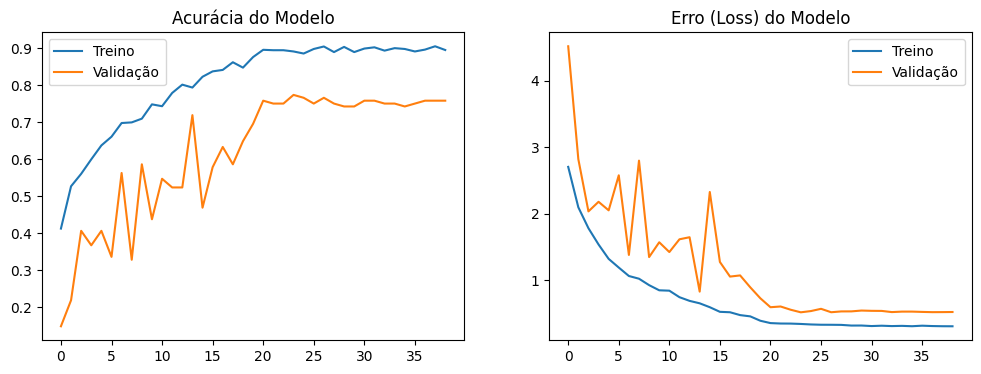

In [30]:
plt.figure(figsize=(12, 4))

# Gráfico de Acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia do Modelo')
plt.legend()

# Gráfico de Perda (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Erro (Loss) do Modelo')
plt.legend()

plt.show()

### O que será avaliado nesta etapa

A avaliação será feita com três visões complementares:

- **Acurácia global** no conjunto de teste.
- **Relatório por classe** (precision, recall e f1-score) para entender desempenho específico de cada arma.
- **Matriz de confusão** para identificar padrões de erro e classes que se sobrepõem acusticamente.

## Análise de Métricas

In [31]:
y_pred_probs = model.predict(X_test_final)

# 2. Pegar o índice da maior probabilidade (A classe vencedora)
# Ex: Se a posição 1 tem 0.8, então a classe predita é 1
y_pred_classes = np.argmax(y_pred_probs, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


In [32]:
# Recupera os nomes das classes originais do seu LabelEncoder
nomes_classes = le.classes_

print("--- Relatório de Classificação ---\n")
print(classification_report(y_test_num, y_pred_classes, target_names=nomes_classes))

--- Relatório de Classificação ---

                  precision    recall  f1-score   support

           AK-12       1.00      1.00      1.00        15
           AK-47       0.92      1.00      0.96        11
IMI Desert Eagle       0.93      0.93      0.93        15
             M16       0.31      0.27      0.29        15
            M249       0.87      0.87      0.87        15
              M4       0.31      0.27      0.29        15
           MG-42       0.87      0.87      0.87        15
             MP5       0.61      0.73      0.67        15
     Zastava M92       1.00      1.00      1.00        12

        accuracy                           0.76       128
       macro avg       0.76      0.77      0.76       128
    weighted avg       0.75      0.76      0.75       128



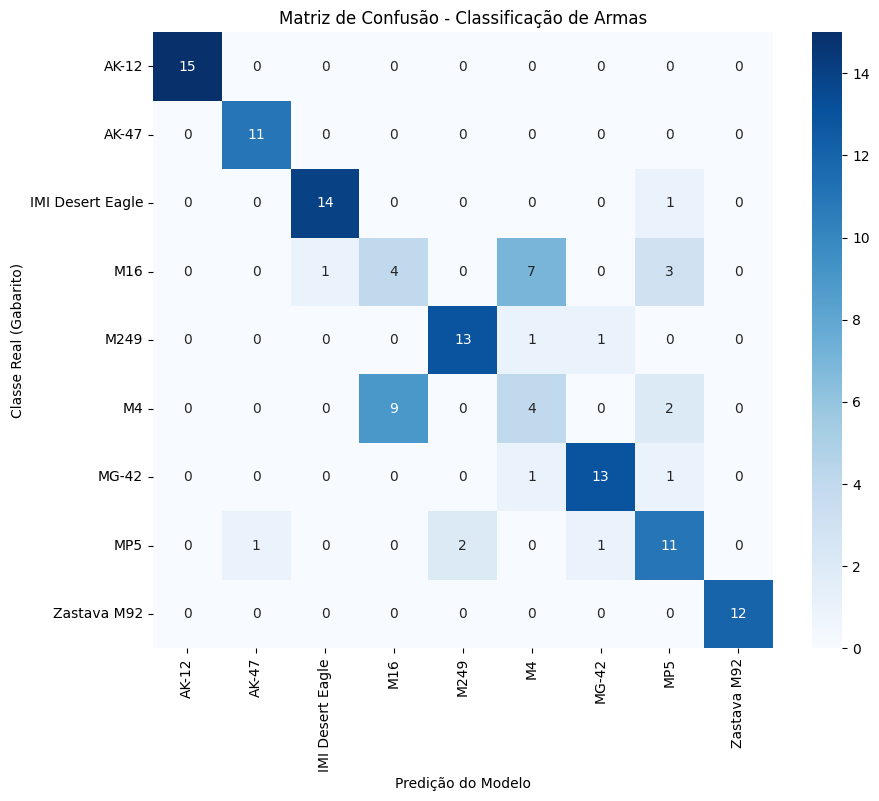

In [33]:
# Gera a matriz matemática
cm = confusion_matrix(y_test_num, y_pred_classes)

# Plota usando Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=nomes_classes,
            yticklabels=nomes_classes)

plt.xlabel('Predição do Modelo')
plt.ylabel('Classe Real (Gabarito)')
plt.title('Matriz de Confusão - Classificação de Armas')
plt.show()

### Leitura da matriz de confusão

A diagonal principal representa os acertos por classe. Já os valores fora da diagonal mostram onde o modelo mais se confunde.

Neste trabalho, os erros entre classes próximas (especialmente entre M16 e M4) são particularmente importantes, porque indicam que o modelo já aprendeu uma assinatura geral de disparos, mas ainda encontra dificuldade em distinguir armas com perfil sonoro muito parecido.

## Carregar melhor modelo
Caso o novo modelo treinado tenha acurácia maior do que 0.62, salvar esse novo modelo com o comando: model.save('model classificacao armas.keras')

In [40]:
loaded_model = tf.keras.models.load_model('modelo_classificacao_armas.keras')

In [41]:
y_pred_probs_load_model = loaded_model.predict(X_test_final)

# 2. Pegar o índice da maior probabilidade (A classe vencedora)
# Ex: Se a posição 1 tem 0.8, então a classe predita é 1
y_pred_classes_load_model = np.argmax(y_pred_probs_load_model, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


In [42]:
nomes_classes = le.classes_

print("--- Relatório de Classificação ---\n")
print(classification_report(y_test_num, y_pred_classes_load_model, target_names=nomes_classes))

--- Relatório de Classificação ---

                  precision    recall  f1-score   support

           AK-12       1.00      1.00      1.00        15
           AK-47       0.92      1.00      0.96        11
IMI Desert Eagle       0.94      1.00      0.97        15
             M16       0.22      0.13      0.17        15
            M249       0.86      0.80      0.83        15
              M4       0.39      0.47      0.42        15
           MG-42       0.79      1.00      0.88        15
             MP5       0.85      0.73      0.79        15
     Zastava M92       1.00      1.00      1.00        12

        accuracy                           0.78       128
       macro avg       0.77      0.79      0.78       128
    weighted avg       0.76      0.78      0.77       128



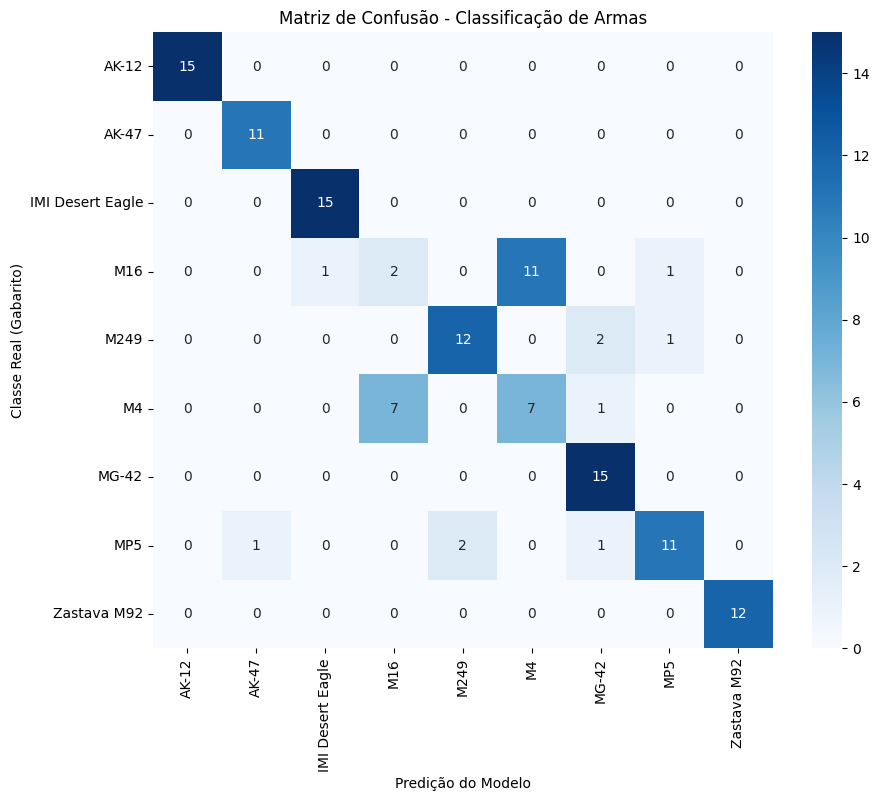

In [43]:
# Gera a matriz matemática
cm = confusion_matrix(y_test_num, y_pred_classes_load_model)

# Plota usando Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=nomes_classes,
            yticklabels=nomes_classes)

plt.xlabel('Predição do Modelo')
plt.ylabel('Classe Real (Gabarito)')
plt.title('Matriz de Confusão - Classificação de Armas')
plt.show()

## Conclusão e análise do erro M16 x M4

Neste notebook foi construída uma pipeline completa de classificação de áudio de disparos: organização do dataset, exploração inicial dos sinais, transformação para mel-espectrogramas, aumento de dados no treino, treinamento de uma CNN e avaliação por relatório de métricas e matriz de confusão.

Os resultados mostram que a abordagem com CNN sobre mel-espectrogramas é viável e consegue separar bem várias classes. Ainda assim, a confusão entre **M16** e **M4** aparece com força. Isso é coerente com o problema: são armas da mesma família, com características mecânicas e assinaturas acústicas próximas, o que tende a produzir padrões de energia parecidos no tempo e na frequência.

Além disso, fatores como reverberação, distância do microfone, ruído de fundo e variação de munição podem reduzir ainda mais a separação entre as duas classes no espaço de features. A célula abaixo compara mel-espectrogramas de uma amostra de cada classe para evidenciar visualmente essa semelhança.

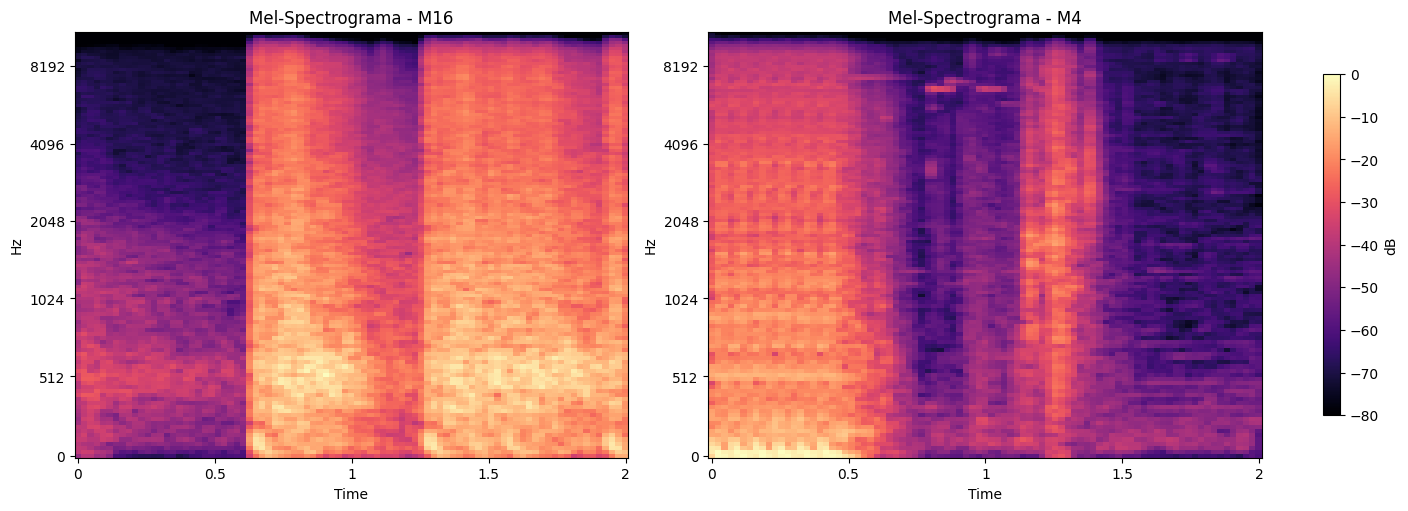

In [38]:
# Comparação visual entre M16 e M4
# Objetivo: investigar se padrões espectrais semelhantes ajudam a explicar a confusão do modelo.

classes_alvo = ["M16", "M4"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

mels_db_cache = {}
for classe in classes_alvo:
    amostra = df_audios[df_audios["label"] == classe]["filepath"].iloc[0]
    y, sr = librosa.load(amostra, sr=SAMPLE_RATE, res_type="kaiser_fast")

    if len(y) < SAMPLES_FIXOS:
        y = librosa.util.fix_length(y, size=SAMPLES_FIXOS)
    else:
        y = y[:SAMPLES_FIXOS]

    mel = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_mels=N_MELS,
        hop_length=HOP_LENGTH,
    )
    mels_db_cache[classe] = librosa.power_to_db(mel, ref=np.max)

vmin = min(m.min() for m in mels_db_cache.values())
vmax = max(m.max() for m in mels_db_cache.values())

for ax, classe in zip(axes, classes_alvo):
    img = librosa.display.specshow(
        mels_db_cache[classe],
        sr=SAMPLE_RATE,
        hop_length=HOP_LENGTH,
        x_axis="time",
        y_axis="mel",
        cmap="magma",
        vmin=vmin,
        vmax=vmax,
        ax=ax,
    )
    ax.set_title(f"Mel-Spectrograma - {classe}")

fig.colorbar(img, ax=axes, location="right", shrink=0.8, label="dB")
plt.show()

In [39]:
import nbformat

def fix_notebook(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        nb = nbformat.read(f, as_version=4)

    # Remove apenas o metadado de widgets que causa o erro no GitHub
    if 'widgets' in nb.metadata:
        del nb.metadata['widgets']
        print(f"Metadados de widgets removidos de {file_path}")
    else:
        print("Nenhum metadado de widget encontrado.")

    with open(file_path, 'w', encoding='utf-8') as f:
        nbformat.write(nb, f)

fix_notebook('notebook.ipynb')

ModuleNotFoundError: No module named 'nbformat'